In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from methods.direct_methods import (
    naive_gauss,
    gauss_partial_pivoting,
    gauss_scaled_pivoting,
    gauss_complete_pivoting,
    LU_factoring,
    LU_solve,
)

from methods.iterative_methods import (
    jacobi,
    gauss_seidel,
    relaxing,
)

from utils.matrix import generate_hilbert_matrix

# Resolução de sistemas de equações lineares

## 1. Exercício

In [2]:
A_5, B_5 = generate_hilbert_matrix(n=5)
A_5_augmented = np.hstack((A_5, B_5.reshape(-1, 1)))

A_9, B_9 = generate_hilbert_matrix(n=9)
A_9_augmented = np.hstack((A_9, B_9.reshape(-1, 1)))

A_15, B_15 = generate_hilbert_matrix(n=15)
A_15_augmented = np.hstack((A_15, B_15.reshape(-1, 1)))

result_dict = {}
A_augmented_list = [A_5_augmented, A_9_augmented, A_15_augmented]
A_list = [A_5, A_9, A_15]
B_list = [B_5, B_9, B_15]
ns = [5, 9, 15]

tol = np.float64(1e-3)
max_iter = 1_000_000
relax_factors = np.array([0.8, 1.12], dtype=np.float64)

### Condicionamento do sistema

In [3]:
determinants = []
cond_numbers = []

for A, B in zip(A_list, B_list):
    determinants.append(np.linalg.det(A))
    cond_numbers.append(np.linalg.cond(A, p=1))

for n, det in zip(ns, determinants):
    print(f"Determinante da matriz de Hilbert de ordem {n}: {det:.4e}")

print("\n")

for n, cond in zip(ns, cond_numbers):
    print(f"Número de condição da matriz de Hilbert de ordem {n}: {cond:.4e}")


Determinante da matriz de Hilbert de ordem 5: 3.7493e-12
Determinante da matriz de Hilbert de ordem 9: 9.7203e-43
Determinante da matriz de Hilbert de ordem 15: -2.1492e-120


Número de condição da matriz de Hilbert de ordem 5: 9.4366e+05
Número de condição da matriz de Hilbert de ordem 9: 1.0997e+12
Número de condição da matriz de Hilbert de ordem 15: 1.2214e+18


Ao analisar os resultados obtidos, observou-se que a matriz de Hilbert está mau condicionada para todos os tamanhos testados. O condicionamento da matriz se tornou pior com dimensões maiores.

Para o teste do determinante, quanto maior a dimensão da matriz, mais o determinante se aproximou de zero, o que indica uma piora no condicionamento.

No teste do número de condição da matriz, o número de condicionamento aumentou para dimensões maiores. Nesse teste, um valor unitário indica bom condicionamento e valores grandes ou distante do valor unitário indicam mau condicionamento.

### Avaliação da convergência para métodos de Jacobi e Gauss-seidel

In [4]:
for n, A in zip(ns, A_list):
    for i in range(A.shape[0]):
        sum = A[i, :].sum()
        sum = sum - A[i, i]

        if np.abs(A[i, i]) < np.abs(sum):
            print(f"A matriz de Hilbert de ordem {n} não é diagonalmente dominante.")
            print(f"Linha {i}: {A[i, i]} < {sum}")
            break

A matriz de Hilbert de ordem 5 não é diagonalmente dominante.
Linha 0: 1.0 < 1.2833333333333332
A matriz de Hilbert de ordem 9 não é diagonalmente dominante.
Linha 0: 1.0 < 1.8289682539682537
A matriz de Hilbert de ordem 15 não é diagonalmente dominante.
Linha 0: 1.0 < 2.3182289932289937


As matrizes de Hilbert de ordem 5, 9 e 15 não são diagonalmente dominante. Logo, não podemos afirmar nada sobre a convergência dos métodos de Jacobi e Gauss-Seidel.

### Resolução do sistema

#### Métodos diretos

##### Calculo

In [5]:
for n, A_i, A_augmented in zip(ns, A_list, A_augmented_list):
    X_true = np.ones_like(A_i[:, 0])

    start_time = time.perf_counter()
    X_naive = naive_gauss(A_augmented)
    gauss_naive_time = time.perf_counter() - start_time
    abs_error_naive = np.linalg.norm(X_naive - X_true, ord=np.inf)
    rel_error_naive = abs_error_naive / np.linalg.norm(X_true, ord=np.inf)

    start_time = time.perf_counter()
    X_partial = gauss_partial_pivoting(A_augmented)
    gauss_partial_time = time.perf_counter() - start_time
    abs_error_partial = np.linalg.norm(X_partial - X_true, ord=np.inf)
    rel_error_partial = abs_error_partial / np.linalg.norm(X_true, ord=np.inf)

    start_time = time.perf_counter()
    X_scaled = gauss_scaled_pivoting(A_augmented)
    gauss_scaled_time = time.perf_counter() - start_time
    abs_error_scaled = np.linalg.norm(X_scaled - X_true, ord=np.inf)
    rel_error_scaled = abs_error_scaled / np.linalg.norm(X_true, ord=np.inf)

    start_time = time.perf_counter()
    X_complete = gauss_complete_pivoting(A_augmented)
    gauss_complete_time = time.perf_counter() - start_time
    abs_error_complete = np.linalg.norm(X_complete - X_true, ord=np.inf)
    rel_error_complete = abs_error_complete / np.linalg.norm(X_true, ord=np.inf)

    result_dict[n] = {
        "gauss_naive": {
            "result": X_naive,
            "time": gauss_naive_time,
            "abs_error": abs_error_naive,
            "rel_error": rel_error_naive,
        },
        "gauss_partial": {
            "result": X_partial,
            "time": gauss_partial_time,
            "abs_error": abs_error_partial,
            "rel_error": rel_error_partial,
        },
        "gauss_scaled": {
            "result": X_scaled,
            "time": gauss_scaled_time,
            "abs_error": abs_error_scaled,
            "rel_error": rel_error_scaled,
        },
        "gauss_complete": {
            "result": X_complete,
            "time": gauss_complete_time,
            "abs_error": abs_error_complete,
            "rel_error": rel_error_complete,
        },
    }

##### Tempo de execução e precisão

In [6]:
df = pd.DataFrame.from_dict(
    {
        "n": [],
        "method": [],
        "time": [],
        "abs_error": [],
        "rel_error": [],
    }
)
for n, results in result_dict.items():
    for method, result in results.items():
        df = pd.concat(
            [
                df,
                pd.DataFrame(
                    {
                        "n": [n],
                        "method": [method],
                        "time": [result["time"]],
                        "abs_error": [result["abs_error"]],
                        "rel_error": [result["rel_error"]],
                    }
                ),
            ],
            ignore_index=True,
        )
df["time"] = df["time"].apply(lambda x: f"{x:.7e} s")
df["abs_error"] = df["abs_error"].apply(lambda x: f"{x:.7e}")
df["rel_error"] = df["rel_error"].apply(lambda x: f"{x:.7e}")
df

,n,method,time,abs_error,rel_error
0,5.0,gauss_naive,4.6876999e-05 s,2.5912605e-12,2.5912605e-12
1,5.0,gauss_partial,4.4827999e-05 s,2.5912605e-12,2.5912605e-12
2,5.0,gauss_scaled,2.5254200e-04 s,2.5912605e-12,2.5912605e-12
3,5.0,gauss_complete,1.4566400e-04 s,2.5910385e-12,2.5910385e-12
4,9.0,gauss_naive,2.4020900e-04 s,1.6869114e-05,1.6869114e-05
5,9.0,gauss_partial,1.4668200e-04 s,1.6869083e-05,1.6869083e-05
6,9.0,gauss_scaled,1.8886800e-04 s,1.6869083e-05,1.6869083e-05
7,9.0,gauss_complete,1.8978200e-04 s,1.6869083e-05,1.6869083e-05
8,15.0,gauss_naive,2.1007800e-03 s,8.3550476e+00,8.3550476e+00
9,15.0,gauss_partial,6.4001800e-04 s,8.3127083e+00,8.3127083e+00


##### Valores de X de cada método

In [7]:
max_n = max(ns)
df_X = pd.DataFrame(columns=["n", "method"] + [f"x{i + 1}" for i in range(max_n)])

for n, results in result_dict.items():
    for method in ["gauss_naive", "gauss_partial", "gauss_scaled", "gauss_complete"]:
        X = results[method]["result"]
        # Preenche com NaN se X for menor que max_n
        row = [n, method] + list(X) + [np.nan] * (max_n - len(X))
        row = row[: 2 + max_n]  # Garante o tamanho correto
        df_X.loc[len(df_X)] = row

df_X

,n,method,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15
0,5,gauss_naive,1.0,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,gauss_partial,1.0,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,gauss_scaled,1.0,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,gauss_complete,1.0,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,gauss_naive,1.0,1.000000,1.000000,1.000002,0.999993,1.000015,0.999983,1.000010,0.999997,NaN,NaN,NaN,NaN,NaN,NaN
5,9,gauss_partial,1.0,1.000000,1.000000,1.000002,0.999993,1.000015,0.999983,1.000010,0.999997,NaN,NaN,NaN,NaN,NaN,NaN
6,9,gauss_scaled,1.0,1.000000,1.000000,1.000002,0.999993,1.000015,0.999983,1.000010,0.999997,NaN,NaN,NaN,NaN,NaN,NaN
7,9,gauss_complete,1.0,1.000000,1.000000,1.000002,0.999993,1.000015,0.999983,1.000010,0.999997,NaN,NaN,NaN,NaN,NaN,NaN
8,15,gauss_naive,1.0,1.000002,0.999995,0.998640,1.025668,0.781933,2.066841,-2.279037,7.532393,-7.355048,7.380667,-1.129041,0.425749,1.733284,0.817952
9,15,gauss_partial,1.0,1.000002,0.999996,0.998634,1.025663,0.782322,2.063961,-2.267832,7.505387,-7.312708,7.337388,-1.101271,0.415689,1.734771,0.817999


#### Métodos iterativos

In [8]:
jacobi_errors = {}
gauss_seidel_errors = {}
relaxing_errors = {}

for n, A_i, A_augmented in zip(ns, A_list, A_augmented_list):
    X_true = np.ones_like(A_i[:, 0])

    try:
        start_time = time.perf_counter()
        X_jacobi, jacobi_errors[n] = jacobi(A_augmented, tol=tol, max_iter=max_iter)
        jacobi_time = time.perf_counter() - start_time
        abs_error_jacobi = np.linalg.norm(X_jacobi - X_true, ord=np.inf)
        rel_error_jacobi = abs_error_jacobi / np.linalg.norm(X_true, ord=np.inf)
    except Exception as e:
        print(f"Erro ao calcular Jacobi para n={n}: {e}")
        X_jacobi = None
        jacobi_time = None
        abs_error_jacobi = None
        rel_error_jacobi = None

    try:
        start_time = time.perf_counter()
        X_gauss_seidel, gauss_seidel_errors[n] = gauss_seidel(A_i, tol=tol, max_iter=max_iter)
        gauss_seidel_time = time.perf_counter() - start_time
        abs_error_gauss_seidel = np.linalg.norm(X_gauss_seidel - X_true, ord=np.inf)
        rel_error_gauss_seidel = abs_error_gauss_seidel / np.linalg.norm(X_true, ord=np.inf)
    except Exception as e:
        print(f"Erro ao calcular Gauss-Seidel para n={n}: {e}")
        X_gauss_seidel = None
        gauss_seidel_time = None
        abs_error_gauss_seidel = None
        rel_error_gauss_seidel = None

    result_dict[n].update(
    {
        "jacobi": {
            "result": X_jacobi,
            "time": jacobi_time,
            "abs_error": abs_error_jacobi,
            "rel_error": rel_error_jacobi,
        },
        "gauss_seidel": {
            "result": X_gauss_seidel,
            "time": gauss_seidel_time,
            "abs_error": abs_error_gauss_seidel,
            "rel_error": rel_error_gauss_seidel,
        }
    })

    relaxing_errors[n] = {}
    for relax_factor in relax_factors:
        try:
            start_time = time.perf_counter()
            X_relaxing, relaxing_errors[n][relax_factor] = relaxing(A_i, relax_factor=relax_factor, tol=tol, max_iter=max_iter)
            relaxing_time = time.perf_counter() - start_time
            abs_error_relaxing = np.linalg.norm(X_relaxing - X_true, ord=np.inf)
            rel_error_relaxing = abs_error_relaxing / np.linalg.norm(X_true, ord=np.inf)
        except Exception as e:
            print(f"Erro ao calcular Relaxamento para n={n}: {e}")
            relaxing_time = None
            abs_error_relaxing = None
            rel_error_relaxing = None

        result_dict[n].update(
            {
                f"relaxing_{relax_factor}": {
                    "result": X_relaxing,
                    "time": relaxing_time,
                    "relax_factor": relax_factor,
                    "abs_error": abs_error_relaxing,
                    "rel_error": rel_error_relaxing,
                }
            }
        )

Erro ao calcular Jacobi para n=5: Solução inválida encontrada.


/home/matheus/Documentos/Meus Codes/metodos_numericos/sistema_equacao/src/methods/iterative_methods.py:61: RuntimeWarning: overflow encountered in scalar divide
  new_solution[i] = (augmented_matrix[i, -1] - sum) / augmented_matrix[i, i]
/home/matheus/Documentos/Meus Codes/metodos_numericos/sistema_equacao/src/methods/iterative_methods.py:56: RuntimeWarning: invalid value encountered in scalar multiply
  sum += augmented_matrix[i, j] * new_solution[j]


Erro ao calcular Jacobi para n=9: Elemento nulo encontrado na diagonal.
Erro ao calcular Jacobi para n=15: Elemento nulo encontrado na diagonal.


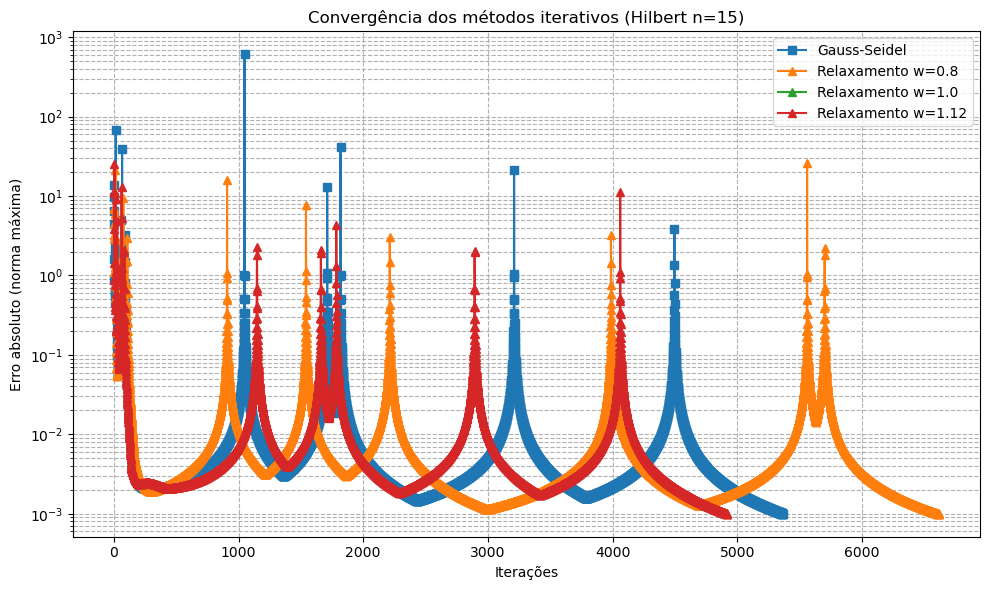

In [20]:
n_plot = 15  # escolha o valor de n desejado (5, 9 ou 15)

plt.figure(figsize=(10, 6))

# Jacobi
if jacobi_errors.get(n_plot) is not None:
    plt.semilogy(jacobi_errors[n_plot], marker='o', label='Jacobi')

# Gauss-Seidel
if gauss_seidel_errors.get(n_plot) is not None:
    plt.semilogy(gauss_seidel_errors[n_plot], marker='s', label='Gauss-Seidel')

# Relaxamento (para cada fator)
if relaxing_errors.get(n_plot) is not None:
    plt.semilogy(relaxing_errors[n_plot].get(0.8, []), marker='^', label='Relaxamento w=0.8')
    plt.semilogy(relaxing_errors[n_plot].get(1.0, []), marker='^', label='Relaxamento w=1.0')
    plt.semilogy(relaxing_errors[n_plot].get(1.12, []), marker='^', label='Relaxamento w=1.12')


plt.xlabel('Iterações')
plt.ylabel('Erro absoluto (norma máxima)')
plt.title(f'Convergência dos métodos iterativos (Hilbert n={n_plot})')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

In [10]:
rows = []
iterative_methods = ["jacobi", "gauss_seidel"] + [f"relaxing_{rf}" for rf in relax_factors]

for n, results in result_dict.items():
    for method, result in results.items():
        if method not in iterative_methods:
            continue
        if "relaxing" in method:
            relax_factor = result["relax_factor"]
            method_name = f"relaxing_{relax_factor}"
        else:
            method_name = method

        rows.append({
            "n": n,
            "method": method_name,
            "time": result["time"],
            "abs_error": result["abs_error"],
            "rel_error": result["rel_error"],
        })

df_3 = pd.DataFrame(rows)
try:
    df_3["time"] = df_3["time"].apply(lambda x: f"{x:.7e} s")
    df_3["abs_error"] = df_3["abs_error"].apply(lambda x: f"{x:.7e}")
    df_3["rel_error"] = df_3["rel_error"].apply(lambda x: f"{x:.7e}")
except ValueError as e:
    print(f"Erro ao converter tipos de dados: {e}")

df_3

,n,method,time,abs_error,rel_error
0,5,jacobi,nan s,nan,nan
1,5,gauss_seidel,3.0987922e-02 s,1.2200112e+00,1.2200112e+00
2,5,relaxing_0.8,4.8315527e-02 s,1.1867916e+00,1.1867916e+00
3,5,relaxing_1.12,2.9077173e-02 s,1.2465484e+00,1.2465484e+00
4,9,jacobi,nan s,nan,nan
5,9,gauss_seidel,8.4448344e-02 s,1.1620265e+00,1.1620265e+00
6,9,relaxing_0.8,1.1049203e-01 s,1.1552555e+00,1.1552555e+00
7,9,relaxing_1.12,9.2365375e-02 s,1.1654992e+00,1.1654992e+00
8,15,jacobi,nan s,nan,nan
9,15,gauss_seidel,3.6914091e-01 s,1.1153440e+00,1.1153440e+00


## 2. Exercício

Algebra Linear e suas Aplicações - Notas de Aula - Petronio Pulino - CAPs[76, 96] PDF

- **Teorema 2.9.7** - Seja A uma matriz de ordem n. Então, a matriz A é invertível se, e somente se, o sistema linear homogêneo AX = 0 possui somente a solução trivial.

- **Corolário 2.9.1** - Seja A uma matriz de ordem n. Então, a matriz A é invertível se, e somente se, o sistema linear AX = Y possui somente uma única solução.

- Condição para Não-Invertibilidade: Se, durante o processo de redução por linha, você obtiver uma matriz na forma escalonada com pelo menos uma linha nula, então a matriz original é não-invertível 

Métodos Numéricos para Engenharia - CAP 257

- Multiplique a inversa pela matriz de coeficientes original e verifique se o resultado está próximo da matriz identidade. Se não, isso indica mal condicionamento. 

- Inverta a matriz invertida e verifique se o resultado está suficientemente próximo da matriz de coeficientes original. Caso contrário, novamente isso pode indicar que o sistema é mal condicionado.

### Matriz 1

In [11]:
A = np.array([[10, 2, -1],
              [-3, -6, 2],
              [1, 1, 5]], dtype=np.float64)
EYE = np.eye(A.shape[0], dtype=np.float64)

#### Verificar se a matriz é invertível

In [12]:
L, U = LU_factoring(A)
print("Matriz U:")
print(U)

Matriz U:
[[10.          2.         -1.        ]
 [ 0.         -5.4         1.7       ]
 [ 0.          0.          5.35185185]]


A Matriz é invertível, a matriz U não tem linhas nula, logo a matriz original é invertível.

In [13]:
determinant = np.linalg.det(A)
print(f"Determinante da matriz A: {determinant:.7e}")

Determinante da matriz A: -2.8900000e+02


#### Calcular a inversa

In [14]:
A_inv = np.zeros_like(A, dtype=np.float64)

for i in range(A.shape[0]):
    tmp_A_augmented = np.hstack((A, EYE[:, i].reshape(-1, 1)))
    X = LU_solve(tmp_A_augmented)

    A_inv[:, i] = X
print("Matriz inversa de A:")
print(A_inv)
print("Verificação da inversa:")
print(np.allclose(A @ A_inv, EYE))
print(np.linalg.inv(A))
print("A @ A inversa:")
print(A @ A_inv)

Matriz inversa de A:
[[ 0.11072664  0.03806228  0.00692042]
 [-0.05882353 -0.17647059  0.05882353]
 [-0.01038062  0.02768166  0.18685121]]
Verificação da inversa:
True
[[ 0.11072664  0.03806228  0.00692042]
 [-0.05882353 -0.17647059  0.05882353]
 [-0.01038062  0.02768166  0.18685121]]
A @ A inversa:
[[ 1.00000000e+00 -1.73472348e-17  0.00000000e+00]
 [-3.12250226e-17  1.00000000e+00  5.55111512e-17]
 [ 5.20417043e-18 -2.42861287e-17  1.00000000e+00]]


### Matriz 2

In [15]:
A2 = np.array([[1, 4, 9, 16],
              [4, 9, 16, 25],
              [9, 16, 25, 36],
              [16, 25, 36, 49]], dtype=np.float64)

EYE2 = np.eye(A2.shape[0], dtype=np.float64)

#### Verificar se a matriz é invertível

In [16]:
L, U = LU_factoring(A2)

print("Matriz U:")
print(U)

Matriz U:
[[ 1.00000000e+00  4.00000000e+00  9.00000000e+00  1.60000000e+01]
 [ 0.00000000e+00 -7.00000000e+00 -2.00000000e+01 -3.90000000e+01]
 [ 0.00000000e+00  0.00000000e+00  1.14285714e+00  3.42857143e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.97379915e-14]]


A Matriz é invertível, a matriz U não tem linhas nula, logo a matriz original é invertível.

In [17]:
determinant = np.linalg.det(A2)
print(f"Determinante da matriz A: {determinant:.7e}")

Determinante da matriz A: -1.7053026e-13


#### Calcular a inversa

In [18]:
A2_inv = np.zeros_like(A2, dtype=np.float64)

for i in range(A2.shape[0]):
    tmp_A_augmented = np.hstack((A2, EYE2[:, i].reshape(-1, 1)))
    X = LU_solve(tmp_A_augmented)

    A2_inv[:, i] = X
print("Matriz inversa de A:")
print(A2_inv)
print("Verificação da inversa:")
print(np.allclose(A2 @ A2_inv, EYE2))
print(np.linalg.inv(A2))
print("A @ A inversa:")
print(A2 @ A2_inv)

Matriz inversa de A:
[[ 2.01053555e+13 -6.03160664e+13  6.03160664e+13 -2.01053555e+13]
 [-6.03160664e+13  1.80948199e+14 -1.80948199e+14  6.03160664e+13]
 [ 6.03160664e+13 -1.80948199e+14  1.80948199e+14 -6.03160664e+13]
 [-2.01053555e+13  6.03160664e+13 -6.03160664e+13  2.01053555e+13]]
Verificação da inversa:
False
[[ 4.69124961e+13 -1.40737488e+14  1.40737488e+14 -4.69124961e+13]
 [-1.40737488e+14  4.22212465e+14 -4.22212465e+14  1.40737488e+14]
 [ 1.40737488e+14 -4.22212465e+14  4.22212465e+14 -1.40737488e+14]
 [-4.69124961e+13  1.40737488e+14 -1.40737488e+14  4.69124961e+13]]
A @ A inversa:
[[ 1.         0.         0.         0.       ]
 [ 0.1171875  1.015625   0.1015625 -0.1171875]
 [ 0.09375    0.8125     0.90625   -0.09375  ]
 [ 1.3046875 -1.109375   2.5390625 -0.1796875]]
